In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2

In [64]:
from pathlib import Path
# include ../../3_Datapreparation
project_dir = Path(os.getcwd()).resolve().parent.parent
sys.path.append(str(project_dir / '3_Data_Preparation'))
from CT_Datasets import CtScanDataset, CtScanDatasetExtended

In [3]:
dataset = CtScanDataset(df_query='BodyPart == "Stamm"', transform=None)

In [4]:
print(dataset[10][0].shape)
print(dataset[10][1])

(511, 512, 512)
58.0


In [5]:
print(dataset[10])

(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [15]:
import torchio as tio

HOUNSFIELD_AIR, HOUNSFIELD_BONE = -1000, 1900

transforms = tio.Compose([
    # Convert the input to a tensor
    v2.Lambda(lambda x: x[:, :, np.newaxis]),
    # dimesion D x W x C x H -> C x W x H x D
    tio.Lambda(lambda x: x.permute(2, 1, 3, 0)),
    # Normalize the pixel values to the range [0, 1]
    tio.RescaleIntensity((HOUNSFIELD_AIR, HOUNSFIELD_BONE), (0, 1)),

    # Crop or Pad the input to the target size (600, 512, 512)
    tio.CropOrPad((512, 512, 600)),
])

# apply the transform to the dataset
transformed = CtScanDataset(df_query='BodyPart == "Stamm"', transform=transforms)

print(transformed[0][0].shape)

d:\Programme\anaconda3\envs\R_D\Lib\site-packages\torchio\transforms\preprocessing\intensity\rescale.py:89: RuntimeWarning: Rescaling image "default_image_name" not possible because all the intensity values are the same
  image.set_data(self.rescale(image.data, mask, image_name))


(1, 512, 512, 600)


d:\Programme\anaconda3\envs\R_D\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


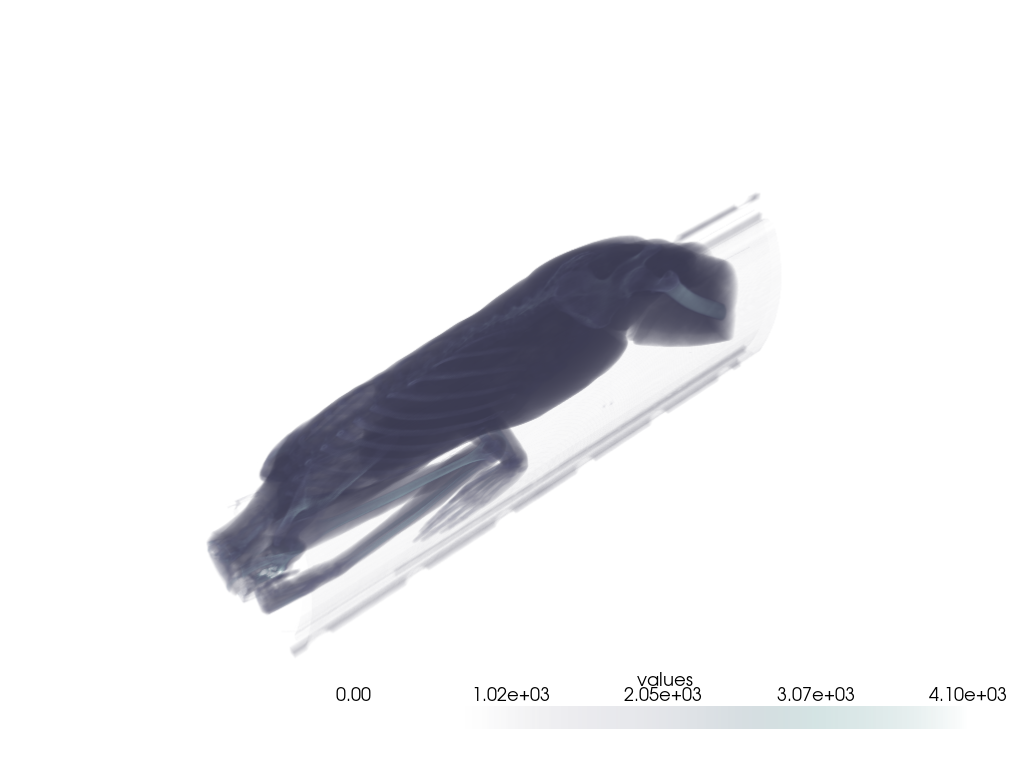

In [17]:
import pyvista as pv
import numpy as np

%matplotlib inline

scan = dataset[10][0]

# Set slice thickness and pixel spacing (adjust these values based on your data)
slice_thickness = 3.0  # Thickness in z-direction
pixel_spacing = [1.171875, 1.171875]  # Spacing in y and x directions

# Create a PyVista grid object from the numpy array
grid = pv.ImageData()

# Set the grid dimensions: shape + 1 because we want to inject our values on the cell data
grid.dimensions = np.array(scan.shape) + 1


# Set the grid spacing
grid.spacing = (slice_thickness, pixel_spacing[0], pixel_spacing[1])  # Spacing in x, y, z directions

# Set the grid origin to (0, 0, 0)
grid.origin = (0, 0, 0)

# Add the data values to the cell data
grid.cell_data["values"] = scan.flatten(order="F")  # Flatten the array in Fortran order

# Visualize the volume
plotter = pv.Plotter()
opacity = [0, 0, 0.1, 0.2, 0.4, 0.6, 1]  # Adjust the opacity transfer function
plotter.add_volume(grid, scalars="values", opacity=opacity, cmap="bone")
plotter.show()

In [19]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import ResNet18_Weights
import torchvision.models.video as video_models

In [2]:
from pathlib import Path
project_dir = Path(os.getcwd()).resolve().parent.parent
sys.path.append(str(project_dir / '4_Modelling/Patrick/medicalNet'))

from setting import Options
from model import generate_model
from logger import log

import torch
import numpy as np
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import time
from scipy import ndimage
import os

In [3]:
# settting
sets = Options()
sets.target_type = "normal"
sets.phase = 'test'
print(vars(sets))

{'data_root': './data', 'img_list': './data/train.txt', 'n_seg_classes': 2, 'learning_rate': 0.001, 'num_workers': 4, 'batch_size': 1, 'phase': 'test', 'save_intervals': 10, 'n_epochs': 200, 'input_D': 56, 'input_H': 448, 'input_W': 448, 'resume_path': '', 'pretrain_path': 'pretrain/resnet_50.pth', 'new_layer_names': ['conv_seg'], 'no_cuda': True, 'gpu_id': None, 'model': 'resnet', 'model_depth': 50, 'resnet_shortcut': 'B', 'manual_seed': 1, 'ci_test': False, 'save_folder': './resnet_50', 'target_type': 'normal'}


In [7]:
# getting model
sets.resume_path = sets.pretrain_path = project_dir / 'Model/3D/resnet_10.pth'
#checkpoint = torch.load(sets.resume_path)
net, _ = generate_model(sets)
#net.load_state_dict(checkpoint['state_dict'])

D:\Studium\0004_Master_ITS\MITS_2.Semester\R_D\inferring_body_weight_from_ct_scans\4_Modelling\Patrick\medicalNet\resnet.py:173: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [100]:
# Load a pretrained ResNet model
resnet = video_models.r3d_18(weights=video_models.R3D_18_Weights.KINETICS400_V1)

# Modify the fully connected layer
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)  # Regression output layer

# Print the modified model (optional)
print(resnet)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to C:\Users\phofm/.cache\torch\hub\checkpoints\r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [01:04<00:00, 2.07MB/s] 

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [54]:
dataset = CtScanDataset(df_query='BodyPart == "Stamm"', transform=transforms)

In [55]:
# train/validation split
train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

In [56]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 5
batch_size = 32

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# Assuming you have your dataset ready
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
print("Device:", device)

Device: cpu


In [57]:
# Initialize lists to store losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    resnet.train()
    running_train_loss = 0.0
    
    # Training loop
    for inputs, targets in train_loader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Compute the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop (no gradients needed)
    resnet.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            outputs = resnet(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_val_loss += loss.item()

    # Compute the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 512, 224, 224] to have 3 channels, but got 512 channels instead

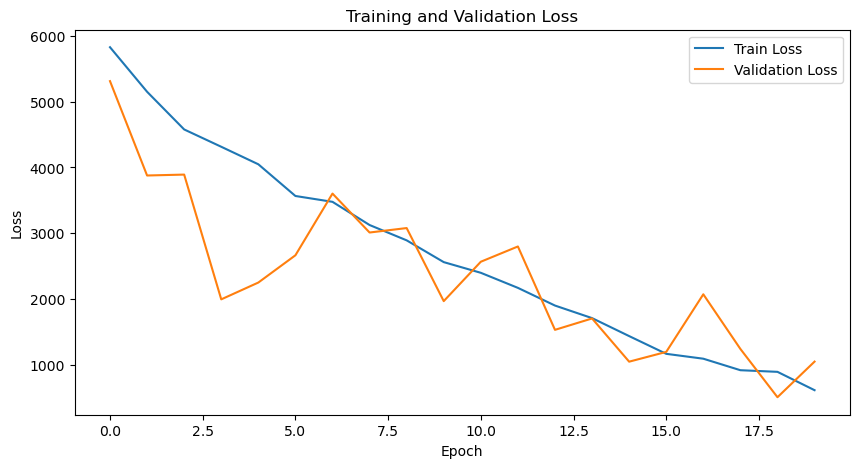

In [15]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
# Save the trained model
torch.save(resnet.state_dict(), "resnet18CT_Rudimentary.pth")